In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

X_train.head()

,ratings,n_votes,runtime,Sci-Fi,Adventure,Game-Show,Short,Horror,War,Animation,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,0.533333,0.111086,0.163121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.788142,0.372118,0.509281,0.513350,0.557162,0.360403,0.541182,0.963265,0.431311,0.856770
1,0.426667,0.000725,0.134752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.891102,0.485300,0.290463,0.424949,0.622690,0.432435,0.454479,0.977497,0.448916,0.899943
2,0.800000,0.304573,0.189716,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.670952,0.263131,0.852748,0.249184,0.251783,0.219996,0.709114,0.892871,0.204739,0.758407
3,0.613333,0.000970,0.180851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.759021,0.385508,0.786574,0.457220,0.466346,0.281163,0.467151,0.930780,0.327420,0.782321
4,0.693333,0.000959,0.278369,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.784980,0.464602,0.594765,0.361956,0.602553,0.572384,0.266610,0.973715,0.458093,0.823935


# 2 Feature selection

## 2.1 Applying PCA to the embeddings
This step is not actually feature *selection*, as we create new features based on the embeddings. Intuitivel, we project these embeddings into lower dimensional spaces, to make further computations faster.

In [3]:
from sklearn.decomposition import PCA

# Apply PCA to image embeddings
X_train_img = X_train.filter(regex=("img_.*"))
X_test_img = X_test.filter(regex=("img_.*"))

pca_img = PCA(n_components=0.8)
X_train_img = pca_img.fit_transform(X_train_img)
X_test_img = pca_img.transform(X_test_img)

PCA_img_list = ['PCA_img_' + str(i) for i in range(pca_img.n_components_)]
X_train_img = pd.DataFrame(X_train_img, columns=PCA_img_list)
X_test_img = pd.DataFrame(X_test_img, columns=PCA_img_list)

X_train.drop(list(X_train.filter(regex = 'img_.*')), axis = 1, inplace = True)
X_train = pd.concat([X_train, X_train_img], axis=1)

X_test.drop(list(X_test.filter(regex = 'img_.*')), axis = 1, inplace = True)
X_test = pd.concat([X_test, X_test_img], axis=1)
#X_train.head()

# Apply PCA to text embeddings
X_train_text = X_train.filter(regex=("text_.*"))
X_test_text = X_test.filter(regex=("text_.*"))

pca_text = PCA(n_components=0.95)
X_train_text = pca_text.fit_transform(X_train_text)
X_test_text = pca_text.transform(X_test_text)

print(pca_text.n_components_)
PCA_text_list = ['PCA_text_' + str(i) for i in range(pca_text.n_components_)]
X_train_text = pd.DataFrame(X_train_text, columns=PCA_text_list)
X_test_text = pd.DataFrame(X_test_text, columns=PCA_text_list)

X_train.drop(list(X_train.filter(regex = 'text_.*')), axis = 1, inplace = True)
X_train = pd.concat([X_train, X_train_text], axis=1)

X_test.drop(list(X_test.filter(regex = 'text_.*')), axis = 1, inplace = True)
X_test = pd.concat([X_test, X_test_text], axis=1)

X_train.head()

25


,ratings,n_votes,runtime,Sci-Fi,Adventure,Game-Show,Short,Horror,War,Animation,...,PCA_text_15,PCA_text_16,PCA_text_17,PCA_text_18,PCA_text_19,PCA_text_20,PCA_text_21,PCA_text_22,PCA_text_23,PCA_text_24
0,0.533333,0.111086,0.163121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.359625,-0.316266,-0.256536,-0.104155,0.203652,0.103937,0.055022,0.024790,-0.052913,-0.127104
1,0.426667,0.000725,0.134752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.054944,-0.286294,-0.135869,-0.196864,0.121437,-0.035862,-0.139215,-0.121679,-0.176535,-0.098030
2,0.800000,0.304573,0.189716,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.259538,0.104968,0.189545,0.020087,-0.174536,0.127739,-0.256170,-0.240080,-0.011664,0.215765
3,0.613333,0.000970,0.180851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.117097,-0.254233,0.267785,0.228389,-0.123110,0.093142,0.412794,-0.254803,-0.128047,0.012092
4,0.693333,0.000959,0.278369,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.251482,0.112882,0.459527,0.109544,0.190601,0.441636,-0.066203,-0.137821,-0.178204,0.186639


## 2.2 Feature selection methods
These methods will be applied to perform a feature selection that is different for each model considered.

In [4]:
def select_features_correlation(X_train, Y_train, X_test, n_feat):
    ##  Return X_train_filtered, X_test_filtered such that they only contain the n_feats
    ##       that are the most correlated to the target
    sorted_corr = np.abs(X_train.corrwith(Y_train)).sort_values(ascending=False)
    kept_cols = sorted_corr.keys()[:n_feat]
    print(kept_cols)
    
    X_train_filtered = X_train[kept_cols]
    X_test_filtered = X_test[kept_cols]
    

    return X_train_filtered, X_test_filtered


from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

def select_features_MI(X_train, Y_train, X_test, n_feat):
    ##  Return X_train_filtered, X_test_filtered such that they only contain the n_feats
    ##       that have the highest mutual informationS
    ## ne fonctionne pas
    mutual_info = pd.Series(mutual_info_regression(X_train, y_train.values.ravel()), index=X_train.columns).sort_values(ascending=False)
    kept_cols = mutual_info.keys()[:n_feat]
    print(kept_cols)
    
    X_train_filtered = X_train[kept_cols]
    X_test_filtered = X_test[kept_cols]

    return X_train_filtered, X_test_filtered


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

def select_features_SFS(estimator, X_train, Y_train, X_test, n_feat):
    sfs_forward = SequentialFeatureSelector(estimator, n_features_to_select=n_feat, direction="forward")
    print("Start of computations")
    sfs_forward.fit(X_train, Y_train)       # this line takes time
    print("Computations done")
    
    selected_features_sfs_forward = X_train.columns[sfs_forward.get_support()]
    print(selected_features_sfs_forward)
    X_train = X_train[selected_features_sfs_forward]
    X_test = X_test[selected_features_sfs_forward]
    return X_train, X_test

# 3 Model selection

## 3.0 Performance metric 

In [5]:
# Compute the Root Mean Square Error
def compute_rmse(predict, target):
    ###################
    # INSERT CODE HERE
    ###################
    ## TODO: PUT your implementation of RMSE  from previous sessions
    ## return rmse
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)


from sklearn.model_selection import KFold

def run_kfold(kf, model, X_train_filtered, y_train):
    ###################
    # INSERT CODE HERE
    ###################
    ## TODO: Implement K-fold Cross Validation for a linear regressor and 
    ##       print the mean and std of the rmse of this cross-validation
    ##
    rmse = []
    
    for train_index, test_index in kf.split(X_train_filtered):
        X_train_kf, X_test_kf = X_train_filtered.iloc[train_index], X_train_filtered.iloc[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model.fit(X_train_kf, y_train_kf.values.ravel())
        y_predict_kf = model.predict(X_test_kf)
        
        rmse_loc = compute_rmse(y_predict_kf, y_test_kf.values.ravel())
        rmse.append(rmse_loc)
        
    print(f"RMSE mean : {np.mean(rmse)}; RMSE std : {np.std(rmse)}")
    
    return


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def perform_grid_search(model_, hyper_params_grid, score_function,X_train, y_train):
    ###################
    # INSERT CODE HERE
    ###################
    ## TODO: 1) define model_ function as model selection criterion using 'make_scorer'
    
    grid = GridSearchCV(model_, param_grid=hyper_params_grid, scoring=score_function)
    grid.fit(X_train, y_train)
    
    return grid

## 3.1 Linear regression

In [6]:
min_RMSE_lin = np.inf
best_n_feat_lin = 2
best_X_train_linear, best_X_test_linear = [], []

for n_feat in range(2, 11):
    print(f'----------- n_features: {n_feat} ---------------------') 
    linear_regressor = LinearRegression()
    X_train_linear, X_test_linear = select_features_MI(X_train, y_train, X_test, n_feat)

    linear_regressor = LinearRegression()
    kf = KFold(n_splits=5)
    run_kfold(kf, linear_regressor, X_train_linear, y_train)

    linear_regressor.fit(X_train_linear, y_train)
    y_pred_lin = linear_regressor.predict(X_test_linear)
    RMSE_test_lin = compute_rmse(y_pred_lin, y_test)
    print("RMSE on test set : ", RMSE_test_lin)
    if RMSE_test_lin < min_RMSE_lin:
        min_RMSE_lin = RMSE_test_lin
        best_n_feat_lin = n_feat
        best_X_train_linear, best_X_test_linear = X_train_linear, X_test_linear

----------- n_features: 2 ---------------------
Index(['studio_pop', 'n_votes'], dtype='object')
RMSE mean : 42470502.167752266; RMSE std : 3934448.3080470697
RMSE on test set :  51569759.63759268
----------- n_features: 3 ---------------------
Index(['studio_pop', 'n_votes', 'years_released'], dtype='object')
RMSE mean : 42222543.128616944; RMSE std : 3839233.389967449
RMSE on test set :  50540525.41063357
----------- n_features: 4 ---------------------
Index(['studio_pop', 'n_votes', 'years_released', 'runtime'], dtype='object')
RMSE mean : 42121356.227338076; RMSE std : 3850244.5502519044
RMSE on test set :  50648247.01617944
----------- n_features: 5 ---------------------
Index(['studio_pop', 'n_votes', 'years_released', 'runtime', 'PCA_text_7'], dtype='object')
RMSE mean : 41911189.22954257; RMSE std : 3897017.301712139
RMSE on test set :  50333103.24481439
----------- n_features: 6 ---------------------
Index(['studio_pop', 'n_votes', 'years_released', 'runtime', 'PCA_text_7',
  

Number of features :  8
RMSE mean : 41847955.379623696; RMSE std : 3921188.8055756693
RMSE on test set :  50057398.04031426


C:\Users\mjaco\AppData\Local\Temp\ipykernel_18344\2169589101.py:14: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(y_pred_lin), np.log(y_test), "o")


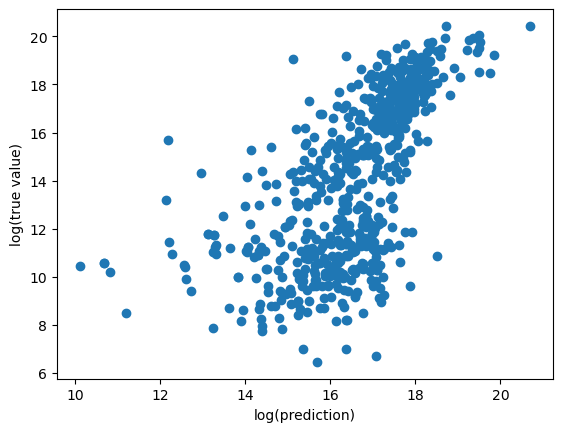

In [7]:
print("Number of features : ", best_n_feat_lin)
linear_regressor = LinearRegression()
X_train_linear, X_test_linear = best_X_train_linear, best_X_test_linear

linear_regressor = LinearRegression()
kf = KFold(n_splits=5)
run_kfold(kf, linear_regressor, X_train_linear, y_train)

linear_regressor.fit(X_train_linear, y_train)
y_pred_lin = linear_regressor.predict(X_test_linear)
RMSE_test_lin = compute_rmse(y_pred_lin, y_test)
print("RMSE on test set : ", RMSE_test_lin)

plt.plot(np.log(y_pred_lin), np.log(y_test), "o")
plt.xlabel("log(prediction)")
plt.ylabel("log(true value)")
plt.savefig("y_pred_lin.pdf")
plt.show()

## 3.2 k-Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsRegressor

min_RMSE_knn = np.inf
best_n_feat_knn = 2
best_X_train_knn, best_X_test_knn = [], []
best_best_params_knn = {}

for n_feat in range(2, 11):
    print(f'----------- n_features: {n_feat} ---------------------') 
    knn_regressor = KNeighborsRegressor()
    X_train_knn, X_test_knn = select_features_MI(X_train, y_train, X_test, n_feat)

    # Perform grid search
    knn_regressor = KNeighborsRegressor()
    param_grid_knn = {'n_neighbors' : np.arange(3,100), 'weights' : ('uniform','distance')}
    scorer = make_scorer(compute_rmse, greater_is_better=False)

    grid_knn = perform_grid_search(knn_regressor, param_grid_knn, scorer, X_train_knn, y_train)

    # Display the best hyperparameters combinations
    res_knn = pd.DataFrame(grid_knn.cv_results_.values(), ).transpose()
    res_knn.columns=grid_knn.cv_results_.keys()
    #print(res_knn.sort_values(by=['rank_test_score'], ascending=True).head())

    # Fit estimator with best hyperparameters
    best_knn = res_knn.loc[res_knn['rank_test_score'] == 1]
    index = best_knn.index[0]
    best_params_knn = res_knn.loc[index]['params']
    #best_params = best_model['params'][index]   # same thing
    print("Best parameters from grid search : ", best_params_knn)

    knn_regressor = KNeighborsRegressor()
    knn_regressor.set_params(**best_params_knn)
    print("All parameters : ", knn_regressor.get_params())

    # Estimate the generalization error with K-Folds CV
    kf = KFold(n_splits=5)
    run_kfold(kf, knn_regressor, X_train_knn, y_train)

    # Compute generalization error on test set
    knn_regressor.fit(X_train_knn, y_train)
    y_pred_knn = knn_regressor.predict(X_test_knn)
    RMSE_test_knn = compute_rmse(y_pred_knn, y_test)
    print("RMSE on test set : ", RMSE_test_knn)
    
    if RMSE_test_knn < min_RMSE_knn:
        min_RMSE_knn = RMSE_test_knn
        best_n_feat_knn = n_feat
        best_X_train_knn, best_X_test_knn = X_train_knn, X_test_knn
        best_best_params_knn = best_params_knn

----------- n_features: 2 ---------------------
Index(['studio_pop', 'n_votes'], dtype='object')
Best parameters from grid search :  {'n_neighbors': 9, 'weights': 'uniform'}
All parameters :  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
RMSE mean : 39136112.59091894; RMSE std : 4165264.624389039
RMSE on test set :  52241869.429768786
----------- n_features: 3 ---------------------
Index(['studio_pop', 'n_votes', 'years_released'], dtype='object')
Best parameters from grid search :  {'n_neighbors': 9, 'weights': 'distance'}
All parameters :  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
RMSE mean : 38660484.50818796; RMSE std : 4327387.253039781
RMSE on test set :  52788396.71669148
----------- n_features: 4 ---------------------
Index(['studio_pop', 'n_votes', 'years_released', 'ru

Number of features :  2
Best parameters from grid search :  {'n_neighbors': 9, 'weights': 'uniform'}
All parameters :  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
RMSE on test set :  52241869.429768786


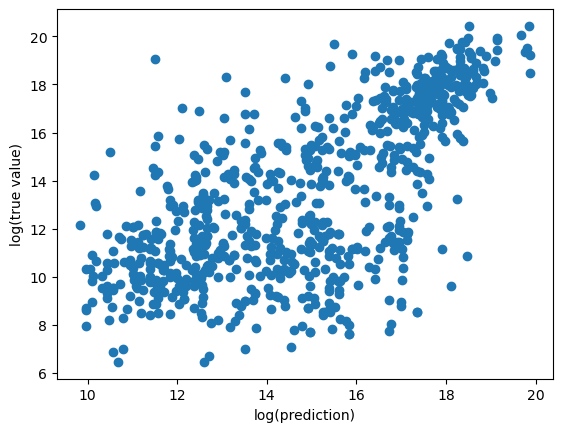

'\nknn_regressor = KNeighborsRegressor()\nX_train_knn, X_test_knn = select_features_SFS(knn_regressor, X_train, y_train, X_test, 10)\n\n# Perform grid search\nknn_regressor = KNeighborsRegressor()\nparam_grid_knn = {\'n_neighbors\' : np.arange(3,100), \'weights\' : (\'uniform\',\'distance\')}\nscorer = make_scorer(compute_rmse, greater_is_better=False)\n\ngrid_knn = perform_grid_search(knn_regressor, param_grid_knn, scorer, X_train_knn, y_train)\n\n# Display the best hyperparameters combinations\nres_knn = pd.DataFrame(grid_knn.cv_results_.values(), ).transpose()\nres_knn.columns=grid_knn.cv_results_.keys()\n#print(res_knn.sort_values(by=[\'rank_test_score\'], ascending=True).head())\n\n# Fit estimator with best hyperparameters\nbest_knn = res_knn.loc[res_knn[\'rank_test_score\'] == 1]\nindex = best_knn.index[0]\nbest_params_knn = res_knn.loc[index][\'params\']\n#best_params = best_model[\'params\'][index]   # same thing\nprint("Best parameters from grid search : ", best_params_knn)\n\

In [9]:
print("Number of features : ", best_n_feat_knn)
X_train_knn, X_test_knn = best_X_train_knn, best_X_test_knn

# Initialize estimator
knn_regressor = KNeighborsRegressor()

# Fit estimator with best hyperparameters
print("Best parameters from grid search : ", best_best_params_knn)

knn_regressor.set_params(**best_best_params_knn)
print("All parameters : ", knn_regressor.get_params())

# Compute generalization error on test set
knn_regressor.fit(X_train_knn, y_train)
y_pred_knn = knn_regressor.predict(X_test_knn)
RMSE_test_knn = compute_rmse(y_pred_knn, y_test)
print("RMSE on test set : ", RMSE_test_knn)

plt.plot(np.log(y_pred_knn), np.log(y_test), "o")
plt.xlabel("log(prediction)")
plt.ylabel("log(true value)")
plt.savefig("y_pred_knn.pdf")
plt.show()



"""
knn_regressor = KNeighborsRegressor()
X_train_knn, X_test_knn = select_features_SFS(knn_regressor, X_train, y_train, X_test, 10)

# Perform grid search
knn_regressor = KNeighborsRegressor()
param_grid_knn = {'n_neighbors' : np.arange(3,100), 'weights' : ('uniform','distance')}
scorer = make_scorer(compute_rmse, greater_is_better=False)

grid_knn = perform_grid_search(knn_regressor, param_grid_knn, scorer, X_train_knn, y_train)

# Display the best hyperparameters combinations
res_knn = pd.DataFrame(grid_knn.cv_results_.values(), ).transpose()
res_knn.columns=grid_knn.cv_results_.keys()
#print(res_knn.sort_values(by=['rank_test_score'], ascending=True).head())

# Fit estimator with best hyperparameters
best_knn = res_knn.loc[res_knn['rank_test_score'] == 1]
index = best_knn.index[0]
best_params_knn = res_knn.loc[index]['params']
#best_params = best_model['params'][index]   # same thing
print("Best parameters from grid search : ", best_params_knn)

knn_regressor = KNeighborsRegressor()
knn_regressor.set_params(**best_params_knn)
print("All parameters : ", knn_regressor.get_params())

# Estimate the generalization error with K-Folds CV
kf = KFold(n_splits=5)
run_kfold(kf, knn_regressor, X_train_knn, y_train)

# Compute generalization error on test set
knn_regressor.fit(X_train_knn, y_train)
y_pred_knn = knn_regressor.predict(X_test_knn)
RMSE_test_knn = compute_rmse(y_pred_knn, y_test)
print("RMSE on test set : ", RMSE_test_knn)

plt.plot(np.log(y_pred_knn), np.log(y_test), "*")
"""

## 3.3 Multi-Layer Perceptron

In [10]:
from sklearn.neural_network import MLPRegressor
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

min_RMSE_mlp = np.inf
best_n_feat_mlp = 2
best_X_train_mlp, best_X_test_mlp = [], []
best_best_params_mlp = {}

for n_feat in range(2, 11):
    print(f'----------- n_features: {n_feat} ---------------------') 
    mlp_regressor = MLPRegressor()
    X_train_mlp, X_test_mlp = select_features_MI(X_train, y_train.values.ravel(), X_test, n_feat)

    # Perform grid search
    mlp_regressor = MLPRegressor()
    #param_grid_mlp = {'hidden_layer_sizes': [j*(i,) for i in [1,100] for j in range(1,4)],
    #                  'activation': ["identity", "logistic", "tanh", "relu"], 'alpha': [0.00001,0.001]}
    param_grid_mlp = {'hidden_layer_sizes': [3*(1,), 3*(100,)],
                      'activation': ["identity", "logistic", "tanh", "relu"], 'alpha': [0.00001,0.001]}
    scorer = make_scorer(compute_rmse, greater_is_better=False)

    grid_mlp = perform_grid_search(mlp_regressor, param_grid_mlp, scorer, X_train_mlp, y_train.values.ravel())

    # Display the best hyperparameters combinations
    res_mlp = pd.DataFrame(grid_mlp.cv_results_.values(), ).transpose()
    res_mlp.columns=grid_mlp.cv_results_.keys()
    #print(res_mlp.sort_values(by=['rank_test_score'], ascending=True).head())

    # Fit estimator with best hyperparameters
    best_mlp = res_mlp.loc[res_mlp['rank_test_score'] == 1]
    index = best_mlp.index[0]
    best_params_mlp = res_mlp.loc[index]['params']
    #best_params = best_model['params'][index]   # same thing
    print("Best parameters from grid search : ", best_params_mlp)

    mlp_regressor = MLPRegressor()
    mlp_regressor.set_params(**best_params_mlp)
    print("All parameters : ", mlp_regressor.get_params())

    # Estimate the generalization error with K-Folds CV
    kf = KFold(n_splits=5)
    run_kfold(kf, mlp_regressor, X_train_mlp, y_train)

    # Compute generalization error on test set
    mlp_regressor.fit(X_train_mlp, y_train.values.ravel())
    y_pred_mlp = mlp_regressor.predict(X_test_mlp)
    RMSE_test_mlp = compute_rmse(y_pred_mlp, y_test)
    print("RMSE on test set : ", RMSE_test_mlp)
    
    if RMSE_test_mlp < min_RMSE_mlp:
        min_RMSE_mlp = RMSE_test_mlp
        best_n_feat_mlp = n_feat
        best_X_train_mlp, best_X_test_mlp = X_train_mlp, X_test_mlp
        best_best_params_mlp = best_params_mlp

----------- n_features: 2 ---------------------
Index(['studio_pop', 'n_votes'], dtype='object')
Best parameters from grid search :  {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100)}
All parameters :  {'activation': 'identity', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
RMSE mean : 51508281.05330868; RMSE std : 3946481.3328181664
RMSE on test set :  63345615.13086216
----------- n_features: 3 ---------------------
Index(['studio_pop', 'n_votes', 'years_released'], dtype='object')
Best parameters from grid search :  {'activation': 'ident

Number of features :  8
Best parameters from grid search :  {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100)}
All parameters :  {'activation': 'identity', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
RMSE on test set :  62693139.60333117


C:\Users\mjaco\AppData\Local\Temp\ipykernel_18344\1344953937.py:19: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(y_pred_mlp), np.log(y_test), "o")


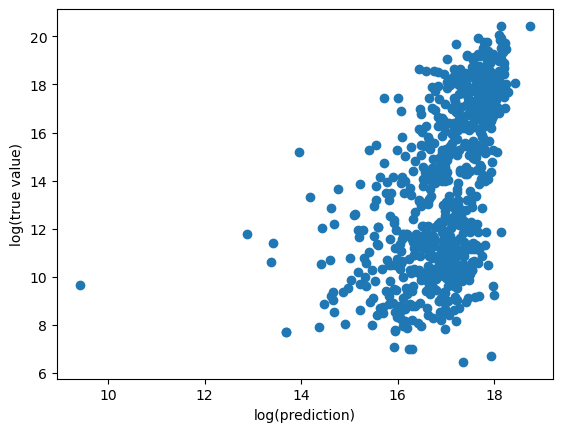

In [11]:
print("Number of features : ", best_n_feat_mlp)
X_train_mlp, X_test_mlp = best_X_train_mlp, best_X_test_mlp

# Initialize estimator
mlp_regressor = MLPRegressor()

# Fit estimator with best hyperparameters
print("Best parameters from grid search : ", best_best_params_mlp)

mlp_regressor.set_params(**best_best_params_mlp)
print("All parameters : ", mlp_regressor.get_params())

# Compute generalization error on test set
mlp_regressor.fit(X_train_mlp, y_train.values.ravel())
y_pred_mlp = mlp_regressor.predict(X_test_mlp)
RMSE_test_mlp = compute_rmse(y_pred_mlp, y_test)
print("RMSE on test set : ", RMSE_test_mlp)

plt.plot(np.log(y_pred_mlp), np.log(y_test), "o")
plt.xlabel("log(prediction)")
plt.ylabel("log(true value)")
plt.savefig("y_pred_mlp.pdf")
plt.show()

## 3.4 Support Vector Regression

In [12]:
from sklearn.svm import SVR

min_RMSE_svr = np.inf
best_n_feat_svr = 2
best_X_train_svr, best_X_test_svr = [], []
best_best_params_svr = {}

for n_feat in range(2, 11):
    print(f'----------- n_features: {n_feat} ---------------------') 
    svr_regressor = SVR()
    X_train_svr, X_test_svr = select_features_MI(X_train, y_train.values.ravel(), X_test, n_feat)

    # Perform grid search
    svr_regressor = SVR()
    param_grid_svr = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C': np.logspace(0,6,7)} # test different orders of magnitude for C
    scorer = make_scorer(compute_rmse, greater_is_better=False)

    grid_svr = perform_grid_search(svr_regressor, param_grid_svr, scorer, X_train_svr, y_train.values.ravel())

    # Display the best hyperparameters combinations
    res_svr = pd.DataFrame(grid_svr.cv_results_.values(), ).transpose()
    res_svr.columns=grid_svr.cv_results_.keys()
    #print(res_svr.sort_values(by=['rank_test_score'], ascending=True).head())

    # Fit estimator with best hyperparameters
    best_svr = res_svr.loc[res_svr['rank_test_score'] == 1]
    index = best_svr.index[0]
    best_params_svr = res_svr.loc[index]['params']
    #best_params = best_model['params'][index]   # same thing
    print("Best parameters from grid search : ", best_params_svr)

    svr_regressor = SVR()
    svr_regressor.set_params(**best_params_svr)
    print("All parameters : ", svr_regressor.get_params())

    # Estimate the generalization error with K-Folds CV
    kf = KFold(n_splits=5)
    run_kfold(kf, svr_regressor, X_train_svr, y_train)

    # Compute generalization error on test set
    svr_regressor.fit(X_train_svr, y_train.values.ravel())
    y_pred_svr = svr_regressor.predict(X_test_svr)
    RMSE_test_svr = compute_rmse(y_pred_svr, y_test)
    print("RMSE on test set : ", RMSE_test_svr)
    
    if RMSE_test_svr < min_RMSE_svr:
        min_RMSE_svr = RMSE_test_svr
        best_n_feat_svr = n_feat
        best_X_train_svr, best_X_test_svr = X_train_svr, X_test_svr
        best_best_params_svr = best_params_svr

----------- n_features: 2 ---------------------
Index(['studio_pop', 'n_votes'], dtype='object')
Best parameters from grid search :  {'C': 100000.0, 'kernel': 'poly'}
All parameters :  {'C': 100000.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
RMSE mean : 48360628.36962303; RMSE std : 4064389.803764165
RMSE on test set :  60133741.362830795
----------- n_features: 3 ---------------------
Index(['studio_pop', 'n_votes', 'years_released'], dtype='object')
Best parameters from grid search :  {'C': 1000000.0, 'kernel': 'poly'}
All parameters :  {'C': 1000000.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
RMSE mean : 48201483.557157405; RMSE std : 6989397.588609804
RMSE on test set :  52955455.31598187
----------- n_features: 4 ---------------------
In

Number of features :  3
Best parameters from grid search :  {'C': 1000000.0, 'kernel': 'poly'}
All parameters :  {'C': 1000000.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
RMSE on test set :  52955455.31598187


C:\Users\mjaco\AppData\Local\Temp\ipykernel_18344\1322111360.py:19: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(y_pred_svr), np.log(y_test), "o")


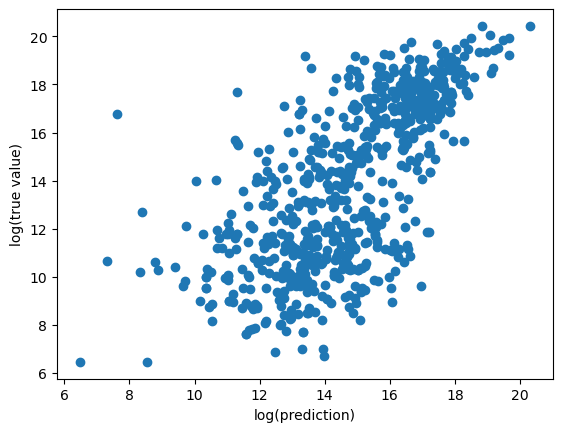

In [13]:
print("Number of features : ", best_n_feat_svr)
X_train_svr, X_test_svr = best_X_train_svr, best_X_test_svr

# Initialize estimator
svr_regressor = SVR()

# Fit estimator with best hyperparameters
print("Best parameters from grid search : ", best_best_params_svr)

svr_regressor.set_params(**best_best_params_svr)
print("All parameters : ", svr_regressor.get_params())

# Compute generalization error on test set
svr_regressor.fit(X_train_svr, y_train.values.ravel())
y_pred_svr = svr_regressor.predict(X_test_svr)
RMSE_test_svr = compute_rmse(y_pred_svr, y_test)
print("RMSE on test set : ", RMSE_test_svr)

plt.plot(np.log(y_pred_svr), np.log(y_test), "o")
plt.xlabel("log(prediction)")
plt.ylabel("log(true value)")
plt.savefig("y_pred_svr.pdf")
plt.show()

## 4 Plotting the results across several train-test splits

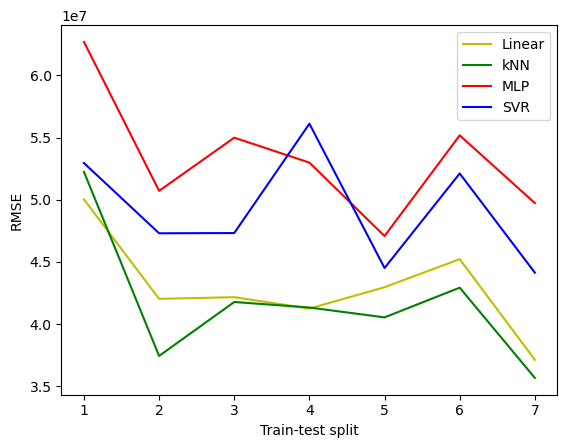

In [14]:
results_lin = np.array([50029355.838494785, 42033227.53344764, 42165574.740493596, 41250049.96517628, 42966528.22259035, 45226536.12138069, 37133030.879085585])
results_knn = np.array([52241869.429768786, 37439633.3094224, 41779417.48826864, 41334140.72246197, 40542322.73878713, 42930251.53197286, 35672900.33321048])
results_mlp = np.array([62692958.66897914, 50715363.664876476, 54992079.59596111, 52987892.32690148, 47081380.83954922, 55179074.108349755, 49731392.048415184])
results_svr = np.array([52955455.31598187, 47303993.64943688, 47323620.75184126, 56114070.32988585, 44512519.84945987, 52115881.33426448, 44137280.39231593])

plt.plot(np.arange(1,8), results_lin, '-y', label="Linear")
plt.plot(np.arange(1,8), results_knn, '-g', label="kNN")
plt.plot(np.arange(1,8), results_mlp, '-r', label="MLP")
plt.plot(np.arange(1,8), results_svr, '-b', label="SVR")

plt.xlabel("Train-test split")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("rmse_4models.pdf")
plt.show()

## 5 Computing our final prediction for X2

In [15]:
X_whole = pd.concat([X_train, X_test], ignore_index=True)
y_whole = pd.concat([y_train, y_test], ignore_index=True)
X2 = pd.read_csv("X2_preprocessed.csv")

print(X_whole.shape)
print(y_whole.values.ravel().shape)

(3276, 174)
(3276,)


In [16]:
n_feat_final = 2
print(f'----------- n_features: {n_feat_final} ---------------------')

# Feature selection
final_regressor = KNeighborsRegressor()
mutual_info_final = pd.Series(mutual_info_regression(X_whole, y_whole.values.ravel()), index=X_whole.columns).sort_values(ascending=False)
kept_cols_final = mutual_info_final.keys()[:n_feat_final]
print(kept_cols_final)
X_final = X_whole[kept_cols_final]
X2_final = X2[kept_cols_final]

# Setting the best hyperparameters
final_regressor = KNeighborsRegressor()
params_final = {'n_neighbors': 9, 'weights': 'uniform'}
final_regressor.set_params(**params_final)

# Estimation of the model's performance
kf = KFold(n_splits=5)
run_kfold(kf, final_regressor, X_final, y_whole)
RMSE_final = 42681859.12846997

# Final results
final_regressor.fit(X_final, y_whole)   # Fit on the whole dataset !
y_pred_final = final_regressor.predict(X2_final)
print(y_pred_final.ravel()[:10])

y2_csv = np.append(y_pred_final.ravel(), RMSE_final)
print(y2_csv.shape)

np.savetxt("Y2.csv", y2_csv)

----------- n_features: 2 ---------------------
Index(['studio_pop', 'n_votes'], dtype='object')
RMSE mean : 42681859.12846997; RMSE std : 5342343.436943125
[6.91818270e+07 2.77217116e+04 2.16142607e+04 6.62528760e+06
 4.46835169e+06 3.15540943e+07 1.32894024e+05 2.00956622e+05
 3.20712511e+06 7.91527613e+05]
(1519,)


In [17]:
pd.read_csv("Y2.csv").head(10)

,6.918182695541718602e+07
0,2.772171e+04
1,2.161426e+04
2,6.625288e+06
3,4.468352e+06
4,3.155409e+07
5,1.328940e+05
6,2.009566e+05
7,3.207125e+06
8,7.915276e+05
9,4.802659e+07
